# 1

## (a)

In [9]:
j=1
reward=10
for i in range(1,200):
    j=j+1
    if (j==6):
        reward=reward+10*(0.9**i)
        j=1
round(reward,4)

24.4194

## (b)

reward=10×(1+0.9^5+0.9^10+0.9^15+0.9^20+...)=10×[(1-0.9^5n)/(1-0.9^5)]
<br>When n→∞, reward→10/(1-0.9^5)

In [4]:
10/(1-0.9**5)

24.419428096993972

## (c)

For the other points, the optimal policy for them is to get to A first and repeat the path between A and A'.

In [6]:
for i in range(7):
    print(24.4*(0.9**i))

24.4
21.96
19.764
17.7876
16.00884
14.407956
12.967160400000001


These are the values in v(s).

# 2

# (a)&(b)

In [4]:
# install OpenAI gym per https://gym.openai.com/docs/
# see scratch_lec05 for all basics of q learning and cartpole in gym
import gym
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
env = gym.make('CartPole-v0')

[2017-11-29 05:06:58,402] Making new env: CartPole-v0


In [6]:
class Replay:
    # accepts a tuple (s,a,r,s') and keeps a list, returns a random batch of tuples as needed
    # remember this is q learning, so a' is not needed (why?... off policy argmax_a)
    def __init__(self):
        self.buffer = []
        self.length = 0
        self.max_length = 100000
        
    def write(self, data):
        if self.length >= self.max_length:
            # drop oldest data point to make room for new
            self.buffer.pop(0)
            self.length -= 1
        self.buffer.append(data)
        self.length += 1
        
    def read(self, batch_size):
        # randomly sample a batch and return a list thereof
        return random.sample(self.buffer,min(batch_size,self.length))

In [6]:
class Network:
    
    def __init__(self, session, n_in , n_out):
        self.session = session
        self.n_in = n_in
        self.n_out = n_out
        self.n_hidden = 60
        # data placeholders
        self.x = tf.placeholder(tf.float32, [None, n_in], name='x')
        self.y = tf.placeholder(tf.float32, [None, n_out], name='y')
        self.x_in = tf.reshape(self.x, [-1,self.n_in])
        # 2 layer network
        self.W_fc1 = tf.get_variable('W_fc1', shape=[self.n_in,self.n_hidden])
        self.b_fc1 = tf.get_variable('b_fc1', shape=[self.n_hidden])
        self.h_fc1 = tf.nn.relu(tf.add(tf.matmul(self.x_in, self.W_fc1), self.b_fc1, name='layer1'))
        self.W_fc2 = tf.get_variable('W_fc2', shape=[self.n_hidden,self.n_out])
        self.b_fc2 = tf.get_variable('b_fc2', shape=[self.n_out])
        self.q = tf.add(tf.matmul(self.h_fc1, self.W_fc2), self.b_fc2, name='layer2')
        # loss, train_step, etc.
        self.loss = tf.reduce_sum(tf.square(self.y - self.q),1)
        self.train_step = tf.train.AdamOptimizer(1e-4).minimize(self.loss)
    
    def compute(self, x):
        # evaluate the network and return the action values [q(s,a=0),q(s,a=1)]
        return self.session.run(self.q, feed_dict={self.x:np.reshape(x,[-1,self.n_in])})
    
    def train(self, x_batch, y_batch):
        # take a training step
        _ = self.session.run(self.train_step, feed_dict={self.x: x_batch, self.y: y_batch})

In [7]:
class Agent: 
    
    def __init__(self, tf_session):
        self.n_in = 4
        self.n_out = 2
        # first what reward has the agent accrued so far
        self.total_reward = 0 
        # discount, learning, exploration rates, batch size
        self.gamma = 0.99
        self.epsilon = 1.0
        self.batch_size = 50
        # make an experience replay buffer
        self.replay_buffer = Replay()
        # make the network that will be the q function
        self.q = Network(tf_session, self.n_in , self.n_out)           
        
    def gather_experience(self, last_observation, action, reward, observation):
        # push this experience onto the replay buffer
        self.replay_buffer.write((last_observation, action, reward, observation))
            
    def choose_action(self, observation):
        # behave according to an epsilon greedy policy
        if np.random.rand() > self.epsilon:
            if self.q.compute(observation)[0,0]>self.q.compute(observation)[0,1]:
                return 0
            else:
                return 1
        else:
            # explore
            return int(np.round(np.random.random()))
        
    def q_update(self):
        # pull a batch from the buffer
        sars_batch = self.replay_buffer.read(self.batch_size)
        # compute the q function for all last_obs and obs
        q_last = self.q.compute([s[0] for s in sars_batch])
        # q_next for current obs requires a bit more attention, since done flag means q should be zero
        q_this = np.zeros_like(q_last) # initialize q to zeros
        ind_not_none = [i for i in range(np.shape(sars_batch)[0]) if sars_batch[i][3] is not None]
        q_this_not_none = self.q.compute([sb[3] for sb in sars_batch if sb[3] is not None])
        # now fill q_this with just the valid q, leaving others [0,0]
        for i in range(len(ind_not_none)):
            q_this[ind_not_none[i],:] = q_this_not_none[i,:]
        # a list comprehension is nice but 5x inefficient... want to pass tensorflow a batch block
        # q_this = [([0,0] if s[3] is None else self.q.compute(s[3])) for s in sars_batch]
        # now chunk this up as the train_step expects
        x_batch = np.zeros([np.shape(sars_batch)[0],self.n_in])
        y_batch = np.zeros([np.shape(sars_batch)[0],self.n_out])
        for i in range(np.shape(sars_batch)[0]):
            x_batch[i,:] = sars_batch[i][0]
            for j in range(2):
                if j == sars_batch[i][1]:
                    # the key step... this is the q learning target
                    y_batch[i,j] = sars_batch[i][2] + self.gamma*np.max(q_this[i])
                else:
                    y_batch[i,j] = q_last[i][j]
        # now run the train step
        self.q.train(x_batch,y_batch)

    def set_epsilon(self,episode):
        # decay exploration from 0.5 to 0.1, but slowly
        # NOTE: performance depends on these decay schedules! Experiment!
        #self.epsilon = 0.01 + (0.5-0.01)/(1 + episode)
        # Note: here is a rate schedule suggested by https://jaromiru.com/2016/10/03/lets-make-a-dqn-implementation/
        self.epsilon = 0.01 + (1.0 - 0.01)*np.exp(-.001*episode)
        
    def reset_epsilon(self):
        # reset method for running greedy after training
        self.epsilon = 0.0

    def gather_reward(self, reward):
        self.total_reward += reward
    def get_total_reward(self):
         return self.total_reward
    def set_total_reward(self, new_total):
         self.total_reward = new_total

In [8]:
# Ensure target log dir exists
import os
LOG_DIR = './tmp/gymexp'
if not os.path.exists(LOG_DIR):
    os.makedirs(LOG_DIR)

After 50 episodes, last 50 rewards averaged 21.36
After 100 episodes, last 50 rewards averaged 19.2
After 150 episodes, last 50 rewards averaged 18.12
After 200 episodes, last 50 rewards averaged 17.12
After 250 episodes, last 50 rewards averaged 18.26
After 300 episodes, last 50 rewards averaged 17.3
After 350 episodes, last 50 rewards averaged 18.24
After 400 episodes, last 50 rewards averaged 18.96
After 450 episodes, last 50 rewards averaged 17.32
After 500 episodes, last 50 rewards averaged 29.1
After 550 episodes, last 50 rewards averaged 39.76
After 600 episodes, last 50 rewards averaged 39.7
After 650 episodes, last 50 rewards averaged 48.12
After 700 episodes, last 50 rewards averaged 48.98
After 750 episodes, last 50 rewards averaged 52.36
After 800 episodes, last 50 rewards averaged 58.88
After 850 episodes, last 50 rewards averaged 59.94
After 900 episodes, last 50 rewards averaged 67.48
After 950 episodes, last 50 rewards averaged 78.72
After 1000 episodes, last 50 rewards

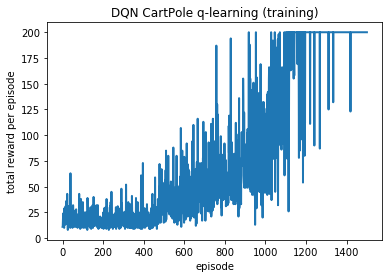

After 50 episodes, last 50 rewards averaged 200.0
After 100 episodes, last 50 rewards averaged 200.0


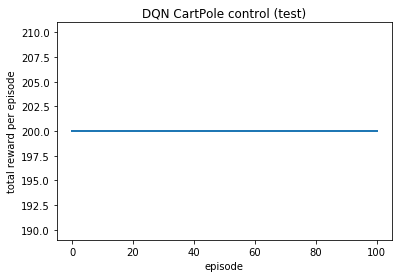

In [15]:
with tf.Graph().as_default():
    ep_rewards = []
    with tf.Session() as sess:
        # create an agent
        agent = Agent(sess)
        # usual tf initialization
        sess.run(tf.global_variables_initializer())      
        ####
        # Q-learn (train) DQN on CartPole
        ####
        for ep in range(1501): 
            # reset environment and agent
            last_observation = env.reset()
            agent.set_total_reward(0)
            # done at T==199 so no reason to go further
            for t in range(201):
                # agent chooses an action
                action = agent.choose_action(last_observation)
                # agent takes the action, and the environment responds
                observation, reward, done, info = env.step(action)
                # check for fail state
                if done==True:
                    observation = None
                # update agent with reward and data
                agent.gather_reward(reward)
                agent.gather_experience(last_observation, action, reward, observation)
                # update q function, which will use the memory
                agent.q_update()
                # iterate
                last_observation = observation
                if done==True:
                    ep_rewards.append(agent.get_total_reward())
                    break
            # print progress...
            if (ep+1) % 50 == 0:
                print('After {} episodes, last 50 rewards averaged {}'.format(ep+1, np.mean(ep_rewards[-50:])))
            # update rates
            agent.set_epsilon(ep)
        plt.plot(ep_rewards, linewidth=2)
        plt.xlabel('episode')
        plt.ylabel('total reward per episode')
        plt.title('DQN CartPole q-learning (training)')
        plt.show()
        
        
        ####
        # Control CartPole with greedy learned DQN (test)
        #### 
        ep_rewards = []
        for ep in range(101): 
            # reset environment and agent
            last_observation = env.reset()
            agent.set_total_reward(0)
            agent.reset_epsilon()
            # done at T==199 so no reason to go further
            for t in range(201):
                env.render()
                action = agent.choose_action(last_observation)
                observation, reward, done, info = env.step(action)
                agent.gather_reward(reward)
                last_observation = observation
                if done==True:
                    ep_rewards.append(agent.get_total_reward())
                    break
            # print progress...
            if (ep+1) % 50 == 0:
                print('After {} episodes, last 50 rewards averaged {}'.format(ep+1, np.mean(ep_rewards[-50:])))
 
        plt.plot(ep_rewards, linewidth=2)
        plt.xlabel('episode')
        plt.ylabel('total reward per episode')
        plt.title('DQN CartPole control (test)')
        plt.show()
        

# (c)

**Summary:** I tried three kinds of adjustments.
<br>(1). Change 2 layers to 3 or 4 layers. I didn't improve the performance this way. It seems that 2 layers is good enough.
<br>(2). Change the hidden layer length to 50 and 70. 50 hidden layer length can improve the performance a bit nut might cause overfitting.
<br>(3). Change the batch size to 30 and 70. I didn't improve the performance this way.

### Change to 3 layers

In [4]:
class Network:
    
    def __init__(self, session, n_in , n_out):
        self.session = session
        self.n_in = n_in
        self.n_out = n_out
        self.n_hidden = 60
        # data placeholders
        self.x = tf.placeholder(tf.float32, [None, n_in], name='x')
        self.y = tf.placeholder(tf.float32, [None, n_out], name='y')
        self.x_in = tf.reshape(self.x, [-1,self.n_in])
        # 3 layer network
        self.W_fc1 = tf.get_variable('W_fc1', shape=[self.n_in,self.n_hidden])
        self.b_fc1 = tf.get_variable('b_fc1', shape=[self.n_hidden])
        self.h_fc1 = tf.nn.relu(tf.add(tf.matmul(self.x_in, self.W_fc1), self.b_fc1, name='layer1'))
        self.W_fc2 = tf.get_variable('W_fc2', shape=[self.n_hidden,self.n_hidden])
        self.b_fc2 = tf.get_variable('b_fc2', shape=[self.n_hidden])
        self.h_fc2 = tf.nn.relu(tf.add(tf.matmul(self.h_fc1, self.W_fc2), self.b_fc2, name='layer2'))
        self.W_fc3 = tf.get_variable('W_fc3', shape=[self.n_hidden,self.n_out])
        self.b_fc3 = tf.get_variable('b_fc3', shape=[self.n_out])
        self.q = tf.add(tf.matmul(self.h_fc2, self.W_fc3), self.b_fc3, name='layer3')
        # loss, train_step, etc.
        self.loss = tf.reduce_sum(tf.square(self.y - self.q),1)
        self.train_step = tf.train.AdamOptimizer(1e-4).minimize(self.loss)
    
    def compute(self, x):
        # evaluate the network and return the action values [q(s,a=0),q(s,a=1)]
        return self.session.run(self.q, feed_dict={self.x:np.reshape(x,[-1,self.n_in])})
    
    def train(self, x_batch, y_batch):
        # take a training step
        _ = self.session.run(self.train_step, feed_dict={self.x: x_batch, self.y: y_batch})

After 50 episodes, last 50 rewards averaged 22.1
After 100 episodes, last 50 rewards averaged 23.64
After 150 episodes, last 50 rewards averaged 21.3
After 200 episodes, last 50 rewards averaged 19.6
After 250 episodes, last 50 rewards averaged 20.76
After 300 episodes, last 50 rewards averaged 34.96
After 350 episodes, last 50 rewards averaged 34.38
After 400 episodes, last 50 rewards averaged 30.08
After 450 episodes, last 50 rewards averaged 52.28
After 500 episodes, last 50 rewards averaged 74.84
After 550 episodes, last 50 rewards averaged 93.74
After 600 episodes, last 50 rewards averaged 92.88
After 650 episodes, last 50 rewards averaged 122.22
After 700 episodes, last 50 rewards averaged 125.16
After 750 episodes, last 50 rewards averaged 128.42
After 800 episodes, last 50 rewards averaged 148.8
After 850 episodes, last 50 rewards averaged 159.82
After 900 episodes, last 50 rewards averaged 170.14
After 950 episodes, last 50 rewards averaged 175.54
After 1000 episodes, last 50 

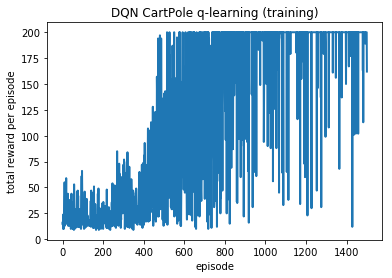

In [8]:
with tf.Graph().as_default():
    ep_rewards = []
    with tf.Session() as sess:
        # create an agent
        agent = Agent(sess)
        # usual tf initialization
        sess.run(tf.global_variables_initializer())      
        ####
        # Q-learn (train) DQN on CartPole
        ####
        for ep in range(1501): 
            # reset environment and agent
            last_observation = env.reset()
            agent.set_total_reward(0)
            # done at T==199 so no reason to go further
            for t in range(201):
                # agent chooses an action
                action = agent.choose_action(last_observation)
                # agent takes the action, and the environment responds
                observation, reward, done, info = env.step(action)
                # check for fail state
                if done==True:
                    observation = None
                # update agent with reward and data
                agent.gather_reward(reward)
                agent.gather_experience(last_observation, action, reward, observation)
                # update q function, which will use the memory
                agent.q_update()
                # iterate
                last_observation = observation
                if done==True:
                    ep_rewards.append(agent.get_total_reward())
                    break
            # print progress...
            if (ep+1) % 50 == 0:
                print('After {} episodes, last 50 rewards averaged {}'.format(ep+1, np.mean(ep_rewards[-50:])))
            # update rates
            agent.set_epsilon(ep)
        plt.plot(ep_rewards, linewidth=2)
        plt.xlabel('episode')
        plt.ylabel('total reward per episode')
        plt.title('DQN CartPole q-learning (training)')
        plt.show()

### Change to 4 layers

In [16]:
class Network:
    
    def __init__(self, session, n_in , n_out):
        self.session = session
        self.n_in = n_in
        self.n_out = n_out
        self.n_hidden = 60
        # data placeholders
        self.x = tf.placeholder(tf.float32, [None, n_in], name='x')
        self.y = tf.placeholder(tf.float32, [None, n_out], name='y')
        self.x_in = tf.reshape(self.x, [-1,self.n_in])
        # 4 layer network
        self.W_fc1 = tf.get_variable('W_fc1', shape=[self.n_in,self.n_hidden])
        self.b_fc1 = tf.get_variable('b_fc1', shape=[self.n_hidden])
        self.h_fc1 = tf.nn.relu(tf.add(tf.matmul(self.x_in, self.W_fc1), self.b_fc1, name='layer1'))
        self.W_fc2 = tf.get_variable('W_fc2', shape=[self.n_hidden,self.n_hidden])
        self.b_fc2 = tf.get_variable('b_fc2', shape=[self.n_hidden])
        self.h_fc2 = tf.nn.relu(tf.add(tf.matmul(self.h_fc1, self.W_fc2), self.b_fc2, name='layer2'))
        self.W_fc3 = tf.get_variable('W_fc3', shape=[self.n_hidden,self.n_hidden])
        self.b_fc3 = tf.get_variable('b_fc3', shape=[self.n_hidden])
        self.h_fc3 = tf.nn.relu(tf.add(tf.matmul(self.h_fc2, self.W_fc3), self.b_fc3, name='layer3'))
        self.W_fc4 = tf.get_variable('W_fc4', shape=[self.n_hidden,self.n_out])
        self.b_fc4 = tf.get_variable('b_fc4', shape=[self.n_out])
        self.q = tf.add(tf.matmul(self.h_fc3, self.W_fc4), self.b_fc4, name='layer4')
        # loss, train_step, etc.
        self.loss = tf.reduce_sum(tf.square(self.y - self.q),1)
        self.train_step = tf.train.AdamOptimizer(1e-4).minimize(self.loss)
    
    def compute(self, x):
        # evaluate the network and return the action values [q(s,a=0),q(s,a=1)]
        return self.session.run(self.q, feed_dict={self.x:np.reshape(x,[-1,self.n_in])})
    
    def train(self, x_batch, y_batch):
        # take a training step
        _ = self.session.run(self.train_step, feed_dict={self.x: x_batch, self.y: y_batch})

After 50 episodes, last 50 rewards averaged 20.26
After 100 episodes, last 50 rewards averaged 22.98
After 150 episodes, last 50 rewards averaged 25.52
After 200 episodes, last 50 rewards averaged 26.84
After 250 episodes, last 50 rewards averaged 33.26
After 300 episodes, last 50 rewards averaged 37.16
After 350 episodes, last 50 rewards averaged 45.66
After 400 episodes, last 50 rewards averaged 56.74
After 450 episodes, last 50 rewards averaged 66.52
After 500 episodes, last 50 rewards averaged 88.14
After 550 episodes, last 50 rewards averaged 90.72
After 600 episodes, last 50 rewards averaged 85.08
After 650 episodes, last 50 rewards averaged 118.28
After 700 episodes, last 50 rewards averaged 133.56
After 750 episodes, last 50 rewards averaged 126.44
After 800 episodes, last 50 rewards averaged 139.92
After 850 episodes, last 50 rewards averaged 151.8
After 900 episodes, last 50 rewards averaged 153.74
After 950 episodes, last 50 rewards averaged 165.72
After 1000 episodes, last 

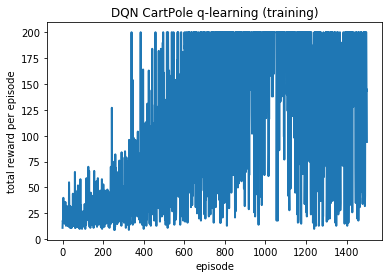

In [17]:
with tf.Graph().as_default():
    ep_rewards = []
    with tf.Session() as sess:
        # create an agent
        agent = Agent(sess)
        # usual tf initialization
        sess.run(tf.global_variables_initializer())      
        ####
        # Q-learn (train) DQN on CartPole
        ####
        for ep in range(1501): 
            # reset environment and agent
            last_observation = env.reset()
            agent.set_total_reward(0)
            # done at T==199 so no reason to go further
            for t in range(201):
                # agent chooses an action
                action = agent.choose_action(last_observation)
                # agent takes the action, and the environment responds
                observation, reward, done, info = env.step(action)
                # check for fail state
                if done==True:
                    observation = None
                # update agent with reward and data
                agent.gather_reward(reward)
                agent.gather_experience(last_observation, action, reward, observation)
                # update q function, which will use the memory
                agent.q_update()
                # iterate
                last_observation = observation
                if done==True:
                    ep_rewards.append(agent.get_total_reward())
                    break
            # print progress...
            if (ep+1) % 50 == 0:
                print('After {} episodes, last 50 rewards averaged {}'.format(ep+1, np.mean(ep_rewards[-50:])))
            # update rates
            agent.set_epsilon(ep)
        plt.plot(ep_rewards, linewidth=2)
        plt.xlabel('episode')
        plt.ylabel('total reward per episode')
        plt.title('DQN CartPole q-learning (training)')
        plt.show()

### Change the hidden layer length to 50

In [18]:
class Network:
    
    def __init__(self, session, n_in , n_out):
        self.session = session
        self.n_in = n_in
        self.n_out = n_out
        self.n_hidden = 50
        # data placeholders
        self.x = tf.placeholder(tf.float32, [None, n_in], name='x')
        self.y = tf.placeholder(tf.float32, [None, n_out], name='y')
        self.x_in = tf.reshape(self.x, [-1,self.n_in])
        # 2 layer network
        self.W_fc1 = tf.get_variable('W_fc1', shape=[self.n_in,self.n_hidden])
        self.b_fc1 = tf.get_variable('b_fc1', shape=[self.n_hidden])
        self.h_fc1 = tf.nn.relu(tf.add(tf.matmul(self.x_in, self.W_fc1), self.b_fc1, name='layer1'))
        self.W_fc2 = tf.get_variable('W_fc2', shape=[self.n_hidden,self.n_out])
        self.b_fc2 = tf.get_variable('b_fc2', shape=[self.n_out])
        self.q = tf.add(tf.matmul(self.h_fc1, self.W_fc2), self.b_fc2, name='layer2')
        # loss, train_step, etc.
        self.loss = tf.reduce_sum(tf.square(self.y - self.q),1)
        self.train_step = tf.train.AdamOptimizer(1e-4).minimize(self.loss)
    
    def compute(self, x):
        # evaluate the network and return the action values [q(s,a=0),q(s,a=1)]
        return self.session.run(self.q, feed_dict={self.x:np.reshape(x,[-1,self.n_in])})
    
    def train(self, x_batch, y_batch):
        # take a training step
        _ = self.session.run(self.train_step, feed_dict={self.x: x_batch, self.y: y_batch})

After 50 episodes, last 50 rewards averaged 23.62
After 100 episodes, last 50 rewards averaged 23.62
After 150 episodes, last 50 rewards averaged 23.12
After 200 episodes, last 50 rewards averaged 23.3
After 250 episodes, last 50 rewards averaged 20.22
After 300 episodes, last 50 rewards averaged 17.64
After 350 episodes, last 50 rewards averaged 19.14
After 400 episodes, last 50 rewards averaged 19.3
After 450 episodes, last 50 rewards averaged 19.5
After 500 episodes, last 50 rewards averaged 18.62
After 550 episodes, last 50 rewards averaged 30.84
After 600 episodes, last 50 rewards averaged 25.9
After 650 episodes, last 50 rewards averaged 32.22
After 700 episodes, last 50 rewards averaged 35.0
After 750 episodes, last 50 rewards averaged 39.46
After 800 episodes, last 50 rewards averaged 45.44
After 850 episodes, last 50 rewards averaged 49.86
After 900 episodes, last 50 rewards averaged 62.2
After 950 episodes, last 50 rewards averaged 55.56
After 1000 episodes, last 50 rewards a

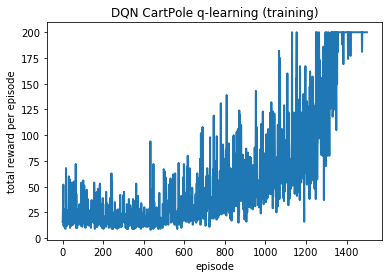

In [19]:
with tf.Graph().as_default():
    ep_rewards = []
    with tf.Session() as sess:
        # create an agent
        agent = Agent(sess)
        # usual tf initialization
        sess.run(tf.global_variables_initializer())      
        ####
        # Q-learn (train) DQN on CartPole
        ####
        for ep in range(1501): 
            # reset environment and agent
            last_observation = env.reset()
            agent.set_total_reward(0)
            # done at T==199 so no reason to go further
            for t in range(201):
                # agent chooses an action
                action = agent.choose_action(last_observation)
                # agent takes the action, and the environment responds
                observation, reward, done, info = env.step(action)
                # check for fail state
                if done==True:
                    observation = None
                # update agent with reward and data
                agent.gather_reward(reward)
                agent.gather_experience(last_observation, action, reward, observation)
                # update q function, which will use the memory
                agent.q_update()
                # iterate
                last_observation = observation
                if done==True:
                    ep_rewards.append(agent.get_total_reward())
                    break
            # print progress...
            if (ep+1) % 50 == 0:
                print('After {} episodes, last 50 rewards averaged {}'.format(ep+1, np.mean(ep_rewards[-50:])))
            # update rates
            agent.set_epsilon(ep)
        plt.plot(ep_rewards, linewidth=2)
        plt.xlabel('episode')
        plt.ylabel('total reward per episode')
        plt.title('DQN CartPole q-learning (training)')
        plt.show()

### Change the hidden layer length to 70

In [21]:
class Network:
    
    def __init__(self, session, n_in , n_out):
        self.session = session
        self.n_in = n_in
        self.n_out = n_out
        self.n_hidden = 70
        # data placeholders
        self.x = tf.placeholder(tf.float32, [None, n_in], name='x')
        self.y = tf.placeholder(tf.float32, [None, n_out], name='y')
        self.x_in = tf.reshape(self.x, [-1,self.n_in])
        # 2 layer network
        self.W_fc1 = tf.get_variable('W_fc1', shape=[self.n_in,self.n_hidden])
        self.b_fc1 = tf.get_variable('b_fc1', shape=[self.n_hidden])
        self.h_fc1 = tf.nn.relu(tf.add(tf.matmul(self.x_in, self.W_fc1), self.b_fc1, name='layer1'))
        self.W_fc2 = tf.get_variable('W_fc2', shape=[self.n_hidden,self.n_out])
        self.b_fc2 = tf.get_variable('b_fc2', shape=[self.n_out])
        self.q = tf.add(tf.matmul(self.h_fc1, self.W_fc2), self.b_fc2, name='layer2')
        # loss, train_step, etc.
        self.loss = tf.reduce_sum(tf.square(self.y - self.q),1)
        self.train_step = tf.train.AdamOptimizer(1e-4).minimize(self.loss)
    
    def compute(self, x):
        # evaluate the network and return the action values [q(s,a=0),q(s,a=1)]
        return self.session.run(self.q, feed_dict={self.x:np.reshape(x,[-1,self.n_in])})
    
    def train(self, x_batch, y_batch):
        # take a training step
        _ = self.session.run(self.train_step, feed_dict={self.x: x_batch, self.y: y_batch})

After 50 episodes, last 50 rewards averaged 23.84
After 100 episodes, last 50 rewards averaged 19.98
After 150 episodes, last 50 rewards averaged 19.56
After 200 episodes, last 50 rewards averaged 20.18
After 250 episodes, last 50 rewards averaged 20.42
After 300 episodes, last 50 rewards averaged 17.94
After 350 episodes, last 50 rewards averaged 15.22
After 400 episodes, last 50 rewards averaged 17.4
After 450 episodes, last 50 rewards averaged 17.22
After 500 episodes, last 50 rewards averaged 19.22
After 550 episodes, last 50 rewards averaged 19.18
After 600 episodes, last 50 rewards averaged 28.26
After 650 episodes, last 50 rewards averaged 43.16
After 700 episodes, last 50 rewards averaged 54.42
After 750 episodes, last 50 rewards averaged 56.68
After 800 episodes, last 50 rewards averaged 61.44
After 850 episodes, last 50 rewards averaged 63.54
After 900 episodes, last 50 rewards averaged 61.4
After 950 episodes, last 50 rewards averaged 70.26
After 1000 episodes, last 50 rewar

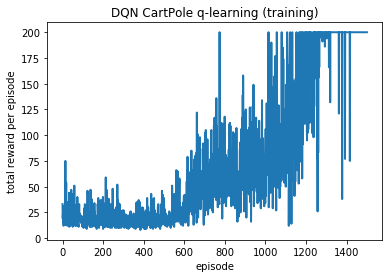

In [22]:
with tf.Graph().as_default():
    ep_rewards = []
    with tf.Session() as sess:
        # create an agent
        agent = Agent(sess)
        # usual tf initialization
        sess.run(tf.global_variables_initializer())      
        ####
        # Q-learn (train) DQN on CartPole
        ####
        for ep in range(1501): 
            # reset environment and agent
            last_observation = env.reset()
            agent.set_total_reward(0)
            # done at T==199 so no reason to go further
            for t in range(201):
                # agent chooses an action
                action = agent.choose_action(last_observation)
                # agent takes the action, and the environment responds
                observation, reward, done, info = env.step(action)
                # check for fail state
                if done==True:
                    observation = None
                # update agent with reward and data
                agent.gather_reward(reward)
                agent.gather_experience(last_observation, action, reward, observation)
                # update q function, which will use the memory
                agent.q_update()
                # iterate
                last_observation = observation
                if done==True:
                    ep_rewards.append(agent.get_total_reward())
                    break
            # print progress...
            if (ep+1) % 50 == 0:
                print('After {} episodes, last 50 rewards averaged {}'.format(ep+1, np.mean(ep_rewards[-50:])))
            # update rates
            agent.set_epsilon(ep)
        plt.plot(ep_rewards, linewidth=2)
        plt.xlabel('episode')
        plt.ylabel('total reward per episode')
        plt.title('DQN CartPole q-learning (training)')
        plt.show()

### Change batch size to 30

In [12]:
class Agent: 
    
    def __init__(self, tf_session):
        self.n_in = 4
        self.n_out = 2
        # first what reward has the agent accrued so far
        self.total_reward = 0 
        # discount, learning, exploration rates, batch size
        self.gamma = 0.99
        self.epsilon = 1.0
        self.batch_size = 30
        # make an experience replay buffer
        self.replay_buffer = Replay()
        # make the network that will be the q function
        self.q = Network(tf_session, self.n_in , self.n_out)           
        
    def gather_experience(self, last_observation, action, reward, observation):
        # push this experience onto the replay buffer
        self.replay_buffer.write((last_observation, action, reward, observation))
            
    def choose_action(self, observation):
        # behave according to an epsilon greedy policy
        if np.random.rand() > self.epsilon:
            if self.q.compute(observation)[0,0]>self.q.compute(observation)[0,1]:
                return 0
            else:
                return 1
        else:
            # explore
            return int(np.round(np.random.random()))
        
    def q_update(self):
        # pull a batch from the buffer
        sars_batch = self.replay_buffer.read(self.batch_size)
        # compute the q function for all last_obs and obs
        q_last = self.q.compute([s[0] for s in sars_batch])
        # q_next for current obs requires a bit more attention, since done flag means q should be zero
        q_this = np.zeros_like(q_last) # initialize q to zeros
        ind_not_none = [i for i in range(np.shape(sars_batch)[0]) if sars_batch[i][3] is not None]
        q_this_not_none = self.q.compute([sb[3] for sb in sars_batch if sb[3] is not None])
        # now fill q_this with just the valid q, leaving others [0,0]
        for i in range(len(ind_not_none)):
            q_this[ind_not_none[i],:] = q_this_not_none[i,:]
        # a list comprehension is nice but 5x inefficient... want to pass tensorflow a batch block
        # q_this = [([0,0] if s[3] is None else self.q.compute(s[3])) for s in sars_batch]
        # now chunk this up as the train_step expects
        x_batch = np.zeros([np.shape(sars_batch)[0],self.n_in])
        y_batch = np.zeros([np.shape(sars_batch)[0],self.n_out])
        for i in range(np.shape(sars_batch)[0]):
            x_batch[i,:] = sars_batch[i][0]
            for j in range(2):
                if j == sars_batch[i][1]:
                    # the key step... this is the q learning target
                    y_batch[i,j] = sars_batch[i][2] + self.gamma*np.max(q_this[i])
                else:
                    y_batch[i,j] = q_last[i][j]
        # now run the train step
        self.q.train(x_batch,y_batch)

    def set_epsilon(self,episode):
        # decay exploration from 0.5 to 0.1, but slowly
        # NOTE: performance depends on these decay schedules! Experiment!
        #self.epsilon = 0.01 + (0.5-0.01)/(1 + episode)
        # Note: here is a rate schedule suggested by https://jaromiru.com/2016/10/03/lets-make-a-dqn-implementation/
        self.epsilon = 0.01 + (1.0 - 0.01)*np.exp(-.001*episode)
        
    def reset_epsilon(self):
        # reset method for running greedy after training
        self.epsilon = 0.0

    def gather_reward(self, reward):
        self.total_reward += reward
    def get_total_reward(self):
         return self.total_reward
    def set_total_reward(self, new_total):
         self.total_reward = new_total

After 50 episodes, last 50 rewards averaged 22.06
After 100 episodes, last 50 rewards averaged 23.34
After 150 episodes, last 50 rewards averaged 20.86
After 200 episodes, last 50 rewards averaged 22.42
After 250 episodes, last 50 rewards averaged 34.3
After 300 episodes, last 50 rewards averaged 35.7
After 350 episodes, last 50 rewards averaged 36.36
After 400 episodes, last 50 rewards averaged 46.9
After 450 episodes, last 50 rewards averaged 49.26
After 500 episodes, last 50 rewards averaged 54.26
After 550 episodes, last 50 rewards averaged 54.0
After 600 episodes, last 50 rewards averaged 80.32
After 650 episodes, last 50 rewards averaged 103.54
After 700 episodes, last 50 rewards averaged 122.92
After 750 episodes, last 50 rewards averaged 151.76
After 800 episodes, last 50 rewards averaged 138.26
After 850 episodes, last 50 rewards averaged 161.18
After 900 episodes, last 50 rewards averaged 164.18
After 950 episodes, last 50 rewards averaged 175.06
After 1000 episodes, last 50 

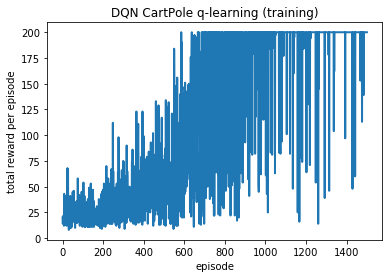

In [13]:
with tf.Graph().as_default():
    ep_rewards = []
    with tf.Session() as sess:
        # create an agent
        agent = Agent(sess)
        # usual tf initialization
        sess.run(tf.global_variables_initializer())      
        ####
        # Q-learn (train) DQN on CartPole
        ####
        for ep in range(1501): 
            # reset environment and agent
            last_observation = env.reset()
            agent.set_total_reward(0)
            # done at T==199 so no reason to go further
            for t in range(201):
                # agent chooses an action
                action = agent.choose_action(last_observation)
                # agent takes the action, and the environment responds
                observation, reward, done, info = env.step(action)
                # check for fail state
                if done==True:
                    observation = None
                # update agent with reward and data
                agent.gather_reward(reward)
                agent.gather_experience(last_observation, action, reward, observation)
                # update q function, which will use the memory
                agent.q_update()
                # iterate
                last_observation = observation
                if done==True:
                    ep_rewards.append(agent.get_total_reward())
                    break
            # print progress...
            if (ep+1) % 50 == 0:
                print('After {} episodes, last 50 rewards averaged {}'.format(ep+1, np.mean(ep_rewards[-50:])))
            # update rates
            agent.set_epsilon(ep)
        plt.plot(ep_rewards, linewidth=2)
        plt.xlabel('episode')
        plt.ylabel('total reward per episode')
        plt.title('DQN CartPole q-learning (training)')
        plt.show()

### Change batch size to 70

In [23]:
class Agent: 
    
    def __init__(self, tf_session):
        self.n_in = 4
        self.n_out = 2
        # first what reward has the agent accrued so far
        self.total_reward = 0 
        # discount, learning, exploration rates, batch size
        self.gamma = 0.99
        self.epsilon = 1.0
        self.batch_size = 70
        # make an experience replay buffer
        self.replay_buffer = Replay()
        # make the network that will be the q function
        self.q = Network(tf_session, self.n_in , self.n_out)           
        
    def gather_experience(self, last_observation, action, reward, observation):
        # push this experience onto the replay buffer
        self.replay_buffer.write((last_observation, action, reward, observation))
            
    def choose_action(self, observation):
        # behave according to an epsilon greedy policy
        if np.random.rand() > self.epsilon:
            if self.q.compute(observation)[0,0]>self.q.compute(observation)[0,1]:
                return 0
            else:
                return 1
        else:
            # explore
            return int(np.round(np.random.random()))
        
    def q_update(self):
        # pull a batch from the buffer
        sars_batch = self.replay_buffer.read(self.batch_size)
        # compute the q function for all last_obs and obs
        q_last = self.q.compute([s[0] for s in sars_batch])
        # q_next for current obs requires a bit more attention, since done flag means q should be zero
        q_this = np.zeros_like(q_last) # initialize q to zeros
        ind_not_none = [i for i in range(np.shape(sars_batch)[0]) if sars_batch[i][3] is not None]
        q_this_not_none = self.q.compute([sb[3] for sb in sars_batch if sb[3] is not None])
        # now fill q_this with just the valid q, leaving others [0,0]
        for i in range(len(ind_not_none)):
            q_this[ind_not_none[i],:] = q_this_not_none[i,:]
        # a list comprehension is nice but 5x inefficient... want to pass tensorflow a batch block
        # q_this = [([0,0] if s[3] is None else self.q.compute(s[3])) for s in sars_batch]
        # now chunk this up as the train_step expects
        x_batch = np.zeros([np.shape(sars_batch)[0],self.n_in])
        y_batch = np.zeros([np.shape(sars_batch)[0],self.n_out])
        for i in range(np.shape(sars_batch)[0]):
            x_batch[i,:] = sars_batch[i][0]
            for j in range(2):
                if j == sars_batch[i][1]:
                    # the key step... this is the q learning target
                    y_batch[i,j] = sars_batch[i][2] + self.gamma*np.max(q_this[i])
                else:
                    y_batch[i,j] = q_last[i][j]
        # now run the train step
        self.q.train(x_batch,y_batch)

    def set_epsilon(self,episode):
        # decay exploration from 0.5 to 0.1, but slowly
        # NOTE: performance depends on these decay schedules! Experiment!
        #self.epsilon = 0.01 + (0.5-0.01)/(1 + episode)
        # Note: here is a rate schedule suggested by https://jaromiru.com/2016/10/03/lets-make-a-dqn-implementation/
        self.epsilon = 0.01 + (1.0 - 0.01)*np.exp(-.001*episode)
        
    def reset_epsilon(self):
        # reset method for running greedy after training
        self.epsilon = 0.0

    def gather_reward(self, reward):
        self.total_reward += reward
    def get_total_reward(self):
         return self.total_reward
    def set_total_reward(self, new_total):
         self.total_reward = new_total

After 50 episodes, last 50 rewards averaged 23.36
After 100 episodes, last 50 rewards averaged 21.02
After 150 episodes, last 50 rewards averaged 22.26
After 200 episodes, last 50 rewards averaged 17.88
After 250 episodes, last 50 rewards averaged 18.54
After 300 episodes, last 50 rewards averaged 19.38
After 350 episodes, last 50 rewards averaged 19.9
After 400 episodes, last 50 rewards averaged 16.68
After 450 episodes, last 50 rewards averaged 27.74
After 500 episodes, last 50 rewards averaged 38.76
After 550 episodes, last 50 rewards averaged 44.72
After 600 episodes, last 50 rewards averaged 46.78
After 650 episodes, last 50 rewards averaged 51.24
After 700 episodes, last 50 rewards averaged 48.88
After 750 episodes, last 50 rewards averaged 54.78
After 800 episodes, last 50 rewards averaged 58.3
After 850 episodes, last 50 rewards averaged 64.16
After 900 episodes, last 50 rewards averaged 72.42
After 950 episodes, last 50 rewards averaged 74.3
After 1000 episodes, last 50 reward

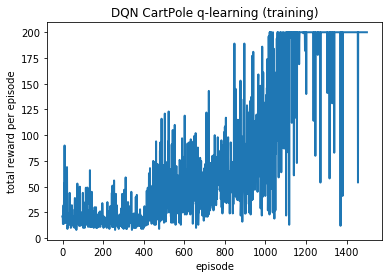

In [24]:
with tf.Graph().as_default():
    ep_rewards = []
    with tf.Session() as sess:
        # create an agent
        agent = Agent(sess)
        # usual tf initialization
        sess.run(tf.global_variables_initializer())      
        ####
        # Q-learn (train) DQN on CartPole
        ####
        for ep in range(1501): 
            # reset environment and agent
            last_observation = env.reset()
            agent.set_total_reward(0)
            # done at T==199 so no reason to go further
            for t in range(201):
                # agent chooses an action
                action = agent.choose_action(last_observation)
                # agent takes the action, and the environment responds
                observation, reward, done, info = env.step(action)
                # check for fail state
                if done==True:
                    observation = None
                # update agent with reward and data
                agent.gather_reward(reward)
                agent.gather_experience(last_observation, action, reward, observation)
                # update q function, which will use the memory
                agent.q_update()
                # iterate
                last_observation = observation
                if done==True:
                    ep_rewards.append(agent.get_total_reward())
                    break
            # print progress...
            if (ep+1) % 50 == 0:
                print('After {} episodes, last 50 rewards averaged {}'.format(ep+1, np.mean(ep_rewards[-50:])))
            # update rates
            agent.set_epsilon(ep)
        plt.plot(ep_rewards, linewidth=2)
        plt.xlabel('episode')
        plt.ylabel('total reward per episode')
        plt.title('DQN CartPole q-learning (training)')
        plt.show()

# 3

## (a)

Bowen Huang  bh2596
<br>Kalabe Haile  kgh2122
<br>Richard Lee  rl2876
<br>Tianyi Wang  tw2567

## (b)

We will do the CIFAR10 dataset classification. It's a image classification problem with ten classes. We will use several CNNs to classify CIFAR10 and compare the performances. 

## (c)

data: CIFAR10
<br>The CIFAR-10 data consists of 60,000 32x32 color images in 10 classes, with 6000 images per class. There are 50,000 training images and 10,000 test images in the official data. 

## (d)

We will first use the logistic regression model to address the problem. And then we will each find an architecture and explore it. The CIFAR10 data are usually classified through CNN models. 

## (e)

The main channge will be to explain clearly how each model works in depth. Coding tensorflow might also be difficult since we are all novices. It will also be difficult to explain the why the performances vary between different architectures.